In [1]:
import h5py
import pandas as pd, numpy as np, matplotlib.pyplot as plt, gunzip
import seaborn as sns
import sys, os
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import random
from scipy.stats import norm
from gtfparse import read_gtf
import csv
import gunzip
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import collections
import qnorm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score 
from collections import Counter

## Helper function for gene length normalization

In [2]:
def gene_length_normalization(df_input,gene_len_info):
    gene_list = list(set(gencode.gene_name).intersection(set(df_input.index)))
    df_input = df_input.loc[gene_list,:]
    for gene in df_input.index:
        df_input.loc[gene,:] = df_input.loc[gene,:]/gene_len_info.length[np.where(gene_len_info.gene_name==gene)[0][0]]
    return df_input

## Read, clean, & normalize expression data

In [3]:
f = h5py.File('../data/archs4_gene_human_v2.1.h5','r')
x1 = f.get('data')
x2 = x1.get('expression')
exp_data = pd.DataFrame(data=x2)
y1 = f.get('meta')
y2 = y1.get('genes')
gene_sym = y2.get('gene_symbol')
gene_id = pd.DataFrame(data=gene_sym,columns=['gene_id'])
gene_id = gene_id.iloc[:,0].apply(lambda s: s.decode('utf-8'))
gene_id = pd.DataFrame(data=gene_id)
y1 = f.get('meta')
y3 = y1.get('samples')
geo_acc = y3.get('geo_accession')
samp_id = pd.DataFrame(data=geo_acc,columns=['geo_acc'])
samp_id = samp_id.iloc[:,0].apply(lambda s: s.decode('utf-8'))
samp_id = pd.DataFrame(data=samp_id)
exp_data.columns = list(samp_id.iloc[:,0])
exp_data.index = list(gene_id.iloc[:,0])
sample_anno = pd.read_csv('../results/sample_annotations_multi_hot',sep='\t',index_col=0)
gencode = read_gtf("../../genome_25kb/data/gencode.v41.annotation.gtf")
gene_len_info = pd.read_csv('../results/gene_length_longest_transcript',sep='\t')

#Keep a random slice of original expression values for testing later
test_biosamples = random.choices(list(Counter(list(exp_data.columns))-Counter(list(sample_anno.index))), k=50000)
test_data = exp_data[test_biosamples]
test_data = qnorm.quantile_normalize(np.log2(1+test_data),axis=1)
test_data = gene_length_normalization(test_data,gene_len_info)
test_data = np.transpose(test_data)

exp_data = exp_data[sample_anno.index]
exp_data = qnorm.quantile_normalize(np.log2(1+exp_data),axis=1)
exp_data = gene_length_normalization(exp_data,gene_len_info)
exp_data = np.transpose(exp_data)

/home/ajoshi/.conda/envs/aj_env/lib/python3.8/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home/ajoshi/.conda/envs/aj_env/lib/python3.8/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


## Visualize Label Frequency, to consider dropping certain labels

<AxesSubplot:>

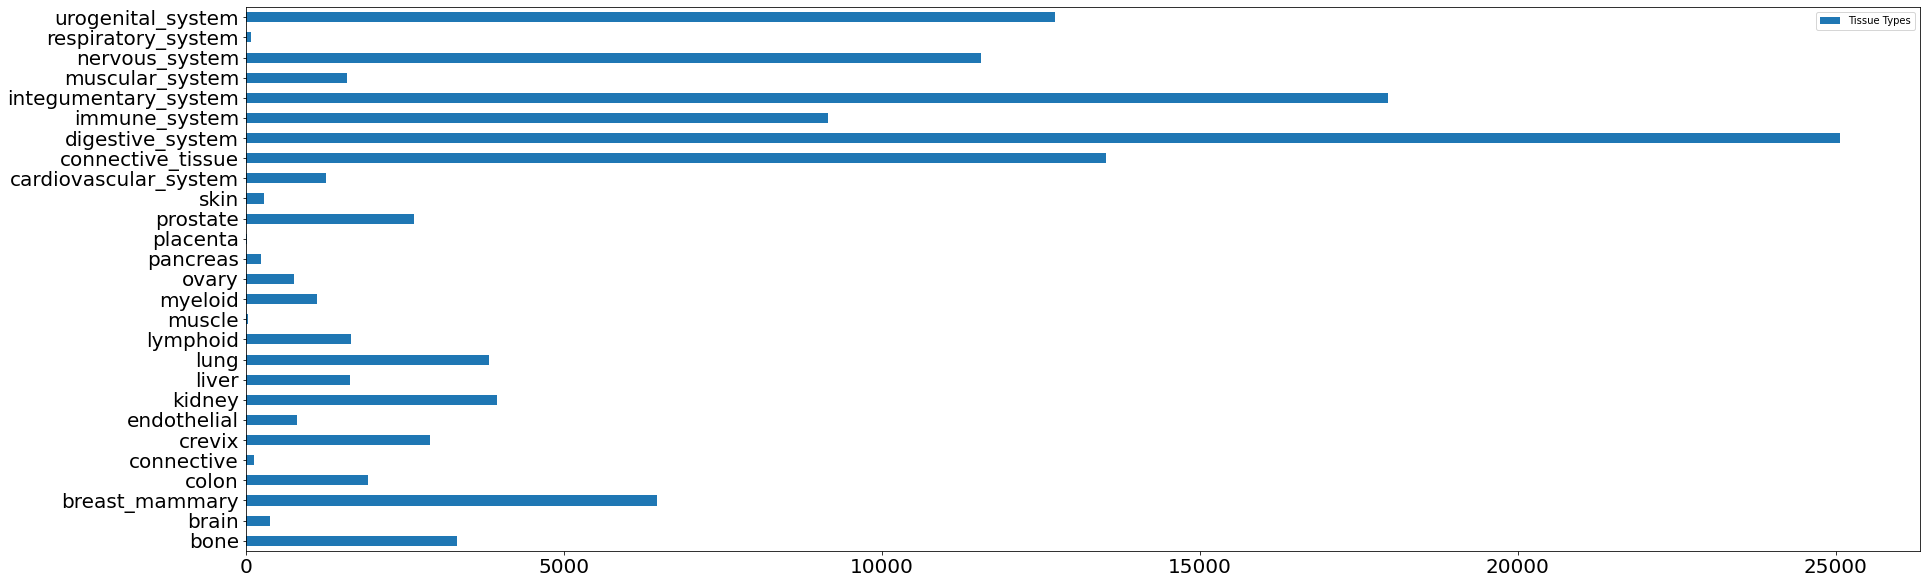

In [4]:
x = {}
for i in sample_anno.columns:
    x[i] = sum(sample_anno.loc[:,i])
temp_df = pd.DataFrame(index=x.keys(),data=x.values(),columns=['Tissue Types'])
temp_df.plot.barh(figsize=(30, 10),fontsize=20)

## Drop labels with less than 500 training examples

In [5]:
drop_list = temp_df.index[np.where(temp_df.iloc[:,0]<500)[0]]
sample_anno = sample_anno.drop(drop_list,axis=1)
sample_anno = sample_anno[~(sample_anno == 0).all(axis=1)]
exp_data = exp_data.loc[sample_anno.index,:]

## Split the data into training and development set

In [6]:
train_x, dev_x, train_y,dev_y = train_test_split(exp_data, sample_anno, test_size=0.33, random_state=1)

## Deep Neural Netwrok based Classification Model

In [7]:
deep_model = keras.Sequential([
    layers.Dense(27, activation="relu",input_dim=train_x.shape[1]),
    layers.Dense(27, activation="relu"),
    layers.Dense(27, activation="relu"),
    layers.Dense(27, activation="relu"),
    layers.Dense(27, activation="relu"),
    layers.Dense(27, activation="relu"),
    layers.Dense(train_y.shape[1], activation="softmax")
])
deep_model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy'])
deep_model.fit(train_x,train_y,batch_size=10000,epochs=30)

2023-01-20 01:19:43.176151: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-20 01:19:43.203029: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 01:19:43.775608: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-20 01:19:58.822138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-20 01:19:58.866480: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2494350000 Hz


Epoch 1/30
9/9 [==============================] - 30s 3s/step - loss: 3.0485 - accuracy: 0.1122
Epoch 2/30
9/9 [==============================] - 25s 3s/step - loss: 2.9105 - accuracy: 0.1399
Epoch 3/30
9/9 [==============================] - 25s 3s/step - loss: 2.7541 - accuracy: 0.0988
Epoch 4/30
9/9 [==============================] - 25s 3s/step - loss: 2.6505 - accuracy: 0.1534
Epoch 5/30
9/9 [==============================] - 25s 3s/step - loss: 2.5957 - accuracy: 0.2068
Epoch 6/30
9/9 [==============================] - 25s 3s/step - loss: 2.5675 - accuracy: 0.2066
Epoch 7/30
9/9 [==============================] - 25s 3s/step - loss: 2.5438 - accuracy: 0.2050
Epoch 8/30
9/9 [==============================] - 25s 3s/step - loss: 2.5188 - accuracy: 0.2065
Epoch 9/30
9/9 [==============================] - 25s 3s/step - loss: 2.5011 - accuracy: 0.2065
Epoch 10/30
9/9 [==============================] - 25s 3s/step - loss: 2.4825 - accuracy: 0.2072
Epoch 11/30
9/9 [======================

## F1 score with neural network model

In [8]:
deep_net_predictions = deep_model.predict(dev_x)
deep_net_predictions = pd.DataFrame(data=deep_net_predictions)
y_deep_pred = tf.cast(tf.greater(deep_net_predictions, 0.3), tf.float32)
f1_score(dev_y, y_deep_pred,average='samples')

0.36216286198745407

## Random Forest Model and F1 score

In [9]:
rf_model = RandomForestClassifier(n_estimators=10)
rf_model.fit(train_x,train_y)
rf_pred = rf_model.predict(dev_x)
rf_pred = pd.DataFrame(data=rf_pred)
f1_score(dev_y, rf_pred,average='samples')

0.8157791866088657